# Predizione e inferenza {#sec-bayesian-regression-prediction}

**Prerequisiti**

- Leggere *Regression and Other Stories* [@gelman2020regression].
  - Prestare particolare attenzione al capitolo 9, "Prediction and Bayesian inference", che offrono una guida dettagliata ai temi della predizione e dell'inferenza nel modello bayesiano di regressione lineare bivariata.

**Concetti e Competenze Chiave**

- Comprendere la distinzione tra l'incertezza associata alla stima della retta di regressione e quella relativa alle predizioni del modello.
- Acquisire la capacità di eseguire e interpretare correttamente i controlli predittivi a priori, valutando la coerenza delle distribuzioni a priori con la conoscenza scientifica disponibile.
- Acquisire la capacità di eseguire e interpretare correttamente i controlli predittivi a posteriori, verificando l'adeguatezza del modello rispetto ai dati osservati e identificando eventuali discrepanze sostanziali che potrebbero richiedere una revisione del modello.

**Preparazione del Notebook**

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel

In [2]:

seed: int = sum(map(ord, "bayesian_regression_prediction"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory
project_directory = os.path.join(home_directory, "_repositories", "psicometria")

def standardize(series):
    """Standardize a pandas series with n degrees of freedom"""
    return (series - series.mean()) / series.std(ddof=0)

## Introduzione {.unnumbered}

@gelman2021regression osservano che l'inferenza bayesiana si sviluppa in tre passaggi fondamentali, che vanno oltre la stima classica. In primo luogo, i dati e il modello vengono combinati per formare una distribuzione a posteriori, che solitamente viene riassunta tramite le distribuzioni a posteriori dei parametri del modello. In secondo luogo, è possibile propagare l'incertezza presente in questa distribuzione, ottenendo previsioni basate su simulazioni per risultati non osservati o futuri, tenendo conto dell'incertezza nei parametri del modello. Infine, è possibile integrare ulteriori informazioni nel modello utilizzando una distribuzione a priori. Questo capitolo si concentra sui temi della previsione e dell'inferenza.

## Predizione

Per discutere i temi della predizione e dell'inferenza bayesiana nel contesto del modello bayesiano di regressione lineare bivariata, esamineremo nuovamente il set di esaminati nel @sec-bivariate-bayesian-regression e relativi alla relazione tra Tense Arousal e ansia di stato.

In [3]:
# Definire il percorso del file CSV
file_path = os.path.join(project_directory, "data", "affect.csv")

# Leggere il file CSV in un DataFrame pandas
data = pd.read_csv(file_path)

# Selezionare le colonne state1 e TA1
df = data[["state1", "TA1"]]

Consideriamo il modello bayesiano di regressione lineare bivariata che include prior uniformi per i parametri $\alpha$, $\beta$ e $\sigma$ che abbiamo discusso nel @sec-bivariate-bayesian-regression. Compiliamo e stampiamo tale modello.

In [4]:
stan_file = os.path.join(project_directory, 'stan', 'arousal_model_prior_raw.stan')
model1 = CmdStanModel(stan_file=stan_file)
print(model1.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 5.0);
  beta ~ normal(0, 2.5);
  sigma ~ cauchy(0, 5.0);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Sistemiamo i dati in un dizionario come richiesto dal modello Stan.

In [5]:
stan_data = {
    "N": len(df["TA1"]),
    "x": df["state1"],
    "y": df["TA1"]
}

Eseguiamo il campionamento MCMC.

In [6]:
fit1 = model1.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [7]:
az.summary(fit1, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.469,1.249,-0.815,3.900,0.027,0.019,2109.0,2603.0,1.0
beta,0.269,0.029,0.212,0.322,0.001,0.000,2078.0,2610.0,1.0
sigma,2.714,0.226,2.302,3.148,0.004,0.003,3571.0,3461.0,1.0


Il punto importante qui è che la distribuzione a posteriori non fornisce solo informazioni sui singoli parametri, ma anche sulle loro interdipendenze. Queste relazioni sono riflesse nei campioni a posteriori, che possono essere trasformati in vari modi. Ad esempio, possiamo calcolare la predizione a posteriori del modello lineare per il valore atteso di Tense Arousal quando l'ansia di stato è pari a 30 usando il seguente comando nel blocco `generated quantities`:

`pred = alpha + beta * 30;`

Modifichiamo il modello Stan che include la specifica di distribuzioni debolmente informative sui  parametri $\alpha$, $\beta$ e $\sigma$ per aggiungere questo comando nel blocco `generated quantities` e compiliamo il modello.

In [8]:
stan_file = os.path.join(project_directory, "stan", "arousal_model2.stan")
model2 = CmdStanModel(stan_file=stan_file)
print(model2.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 5.0);
  beta ~ normal(0, 2.5);
  sigma ~ cauchy(0, 5.0);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
  real pred; // predizione
  
  pred = alpha + beta * 30;
}



In questo modello Stan aggiornato, il blocco `generated quantities` calcola la predizione a posteriori `pred` per una variabile predittore con valore 30. Questa modifica permette di ottenere la distribuzione a posteriori della predizione per un valore specifico del predittore.

Eseguiamo il campionamento.

In [9]:
fit2 = model2.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la stima a posteriori del valore atteso di Tense Arousal quando l'ansia di stato è pari a 30. Questa analisi fornirà sia una stima puntuale di Tense Arousal che una misura dell'incertezza associata, rappresentata dall'intervallo di credibilità al livello di confidenza scelto.

In [10]:
az.summary(fit2, var_names=(["pred"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred,9.544,0.442,8.713,10.381,0.008,0.005,3443.0,4427.0,1.0


## Quantificazione dell'incertezza

Per quantificare l'incertezza complessiva nelle predizioni del modello, possiamo calcolare la distribuzione a posteriori delle predizioni per tutti i valori di $x$ del campione. Questo ci permette di ottenere sia le stime puntuali delle predizioni sia una misura dell'incertezza associata.

Per fare ciò, modifichiamo il blocco `generated quantities` nel seguente modo:

```stan
generated quantities {
  vector[N] y_rep; // Predizioni a posteriori per ciascun valore di x
  
  for (n in 1:N) {
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}
```

Esaminiamo le modifiche:

1. **Dichiarazione del vettore `y_rep`**:

   - `vector[N] y_rep;`: Dichiara un vettore `y_rep` di lunghezza `N` per contenere le predizioni a posteriori per ciascun valore di `x`.

2. **Ciclo `for` per generare le predizioni**:

   - `for (n in 1:N)`: Itera su tutte le osservazioni.
   - `y_rep[n] = normal_rng(alpha + beta * x[n], sigma);`: Per ogni valore di `x[n]`, genera una predizione dalla distribuzione normale con media `alpha + beta * x[n]` e deviazione standard `sigma`. La funzione `normal_rng` genera numeri casuali dalla distribuzione normale specificata, rappresentando l'incertezza nelle predizioni.

Questo approccio consente di ottenere la distribuzione a posteriori delle predizioni, fornendo una visione completa dell'incertezza associata. Dalla distribuzione a posteriori di `y_rep`, possiamo calcolare sia la stima puntuale (come la media o la mediana delle predizioni) sia gli intervalli di credibilità (come l'intervallo al 95%) per ogni valore di `x`. Questo offre una misura dell'incertezza delle predizioni, riflettendo la variabilità e l'affidabilità del modello.

Modifichiamo il modello imponendo distribuzioni a priori debolmente informative sui parametri:

- Per $\alpha$ e $\beta$, utilizziamo una distribuzione Normale centrata su 0 con una deviazione standard di 2.
- Per $\sigma$, utilizziamo una distribuzione di Cauchy centrata su 0 con una scala di 2.

In [11]:
stan_file = os.path.join(project_directory, "stan", "arousal_model3.stan")
model3 = CmdStanModel(stan_file=stan_file)
print(model3.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 5.0);
  beta ~ normal(0, 1.0);
  sigma ~ cauchy(0, 1.0);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
  vector[N] y_rep; // variabili predette
  
  for (n in 1 : N) {
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}



Eseguiamo il campionamento.

In [12]:
fit3 = model3.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori dei parametri.

In [13]:
az.summary(fit3, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.436,1.227,-0.926,3.694,0.026,0.020,2185.0,2421.0,1.0
beta,0.270,0.029,0.217,0.324,0.001,0.000,2050.0,2391.0,1.0
sigma,2.679,0.219,2.264,3.070,0.004,0.003,3724.0,3418.0,1.0


### Manipolare le Stime a Posteriori dei Parametri

Costruiamo ora un grafico che rappresenta i valori osservati insieme alla linea di regressione stimata tramite il modello bayesiano. Al grafico aggiungeremo diverse linee di regressione, ciascuna orientata in base ai valori campionati casualmente dalla distribuzione a posteriori dei parametri $\alpha$ e $\beta$.

Poniamoci dunque il problema di recuperare le stime a posteriori dei parametri dall'oggetto `fit3`, creato dal metodo `sample()`. La [User's Guide](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#accessing-the-results) specifica quanto segue:

> The sampler outputs are the set of per-chain Stan CSV files, a non-standard CSV file format. Each data row of the Stan CSV file contains the per-iteration estimate of the Stan model parameters, transformed parameters, and generated quantities variables. 

Utilizzando il metodo `stan_variable()`, possiamo ottenere un `numpy.ndarray` la cui struttura corrisponde a quella delle variabili del programma Stan, ossia i valori della distribuzione a posteriori di ciascun parametro. In questo caso, otteniamo i valori della distribuzione a posteriori di $\alpha$ e $\beta$:

In [14]:
# Extract posterior samples
alpha_samples = fit3.stan_variable("alpha")
beta_samples = fit3.stan_variable("beta")

Per esempio, stampiamo i primi 20 valori di `alpha_samples`:

In [15]:
print(alpha_samples[0:20])

[ 2.01713    2.37308    1.14274    2.80078    3.10586    1.77013
  1.77256    0.529561   1.81511    0.0353212  0.125      0.722485
 -0.0975432 -0.364862   0.0669098 -1.44573   -2.34803   -1.87964
 -1.9525    -0.156463 ]


In [16]:
len(alpha_samples)

8000

Avendo ottenuto 8,000 stime della distribuzione a posteriori dei parametri $\alpha$ e $\beta$ (2,000 valori per ciascuna delle 4 catene), possiamo calcolare la stima puntuale a posteriori dei parametri nel seguente modo:

In [17]:
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)

print(mean_alpha, mean_beta)

1.4358008241905 0.26977196924999997


Possiamo sovrapporre la retta di regressione al grafico a dispersione utilizzando le stime a posteriori dei parametri.

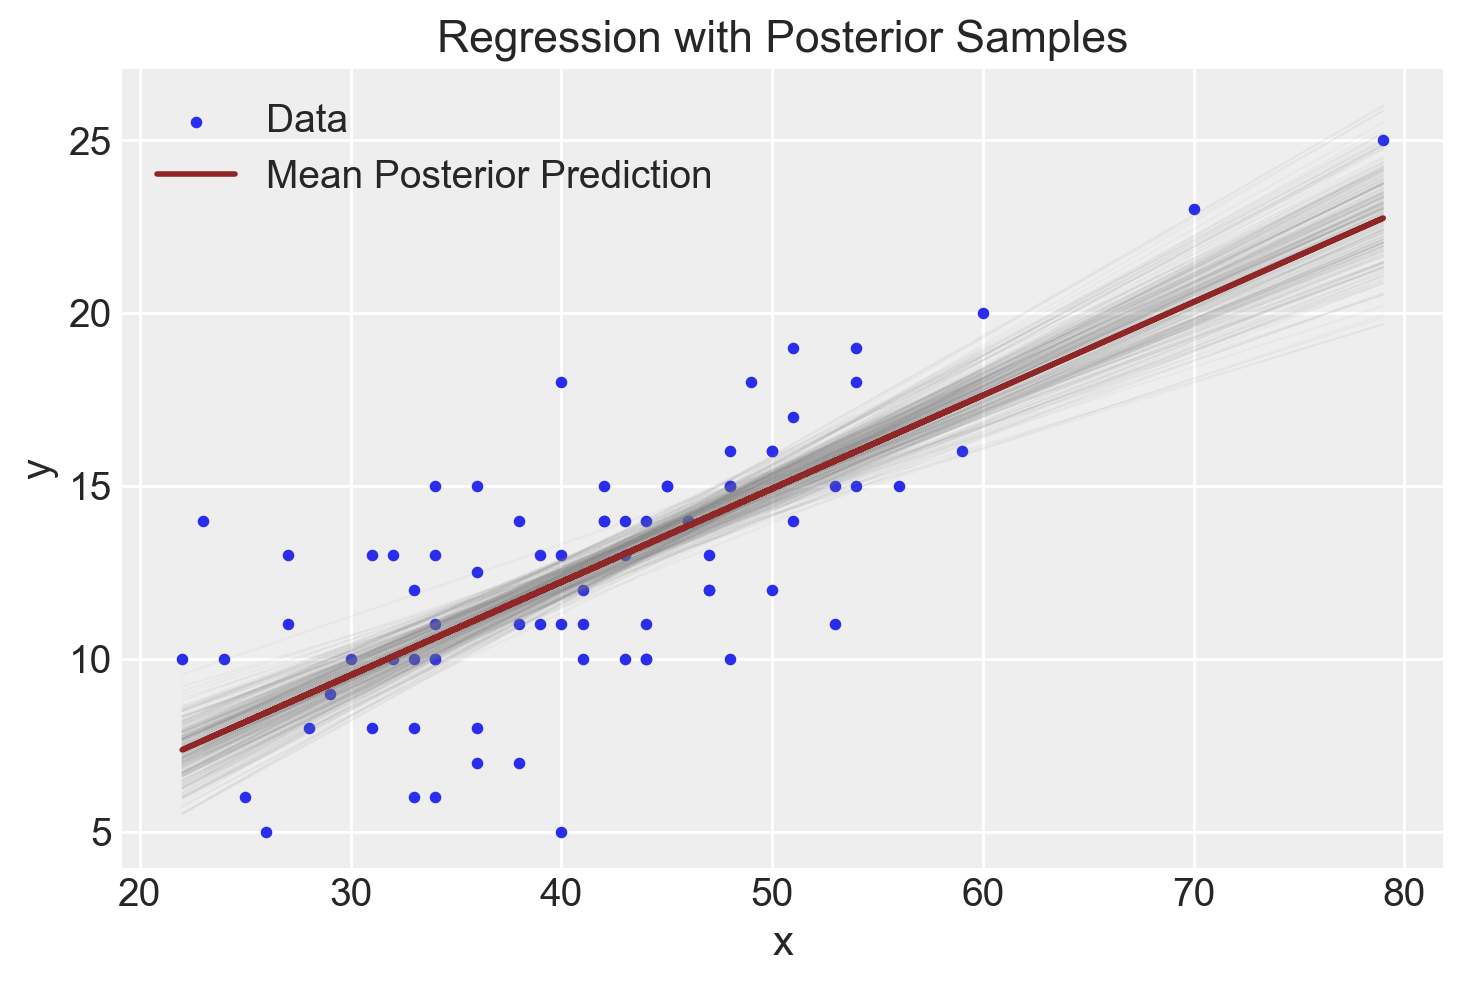

In [18]:
# Plot y vs x
x = df["state1"] 
plt.scatter(
    x, df["TA1"], label="Data", s=10
)  # s is the size of the point

# Draw lines from posterior samples
for i in range(300):  # assuming you have at least 300 samples
    plt.plot(
        x,
        alpha_samples[i] + beta_samples[i] * x,
        color="gray",
        linestyle="-",
        linewidth=0.5,
        alpha=0.05,
    )

# Line using the mean of posterior estimates
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)
color_edge = "#8f2727"
plt.plot(
    x,
    mean_alpha + mean_beta * x,
    color=color_edge,
    linewidth=2,
    label="Mean Posterior Prediction",
)

# Additional plot formatting
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression with Posterior Samples")
plt.legend()
plt.show()

Le numerose linee di regressione presenti nel grafico visualizzano la nostra incertezza riguardo l'inclinazione esatta della linea di regressione principale. Tuttavia, il grafico mostra chiaramente che questa incertezza è minima.

Possiamo procedere in un altro modo per descrivere l'incertezza della stima. Anziché utilizzare le distribuzioni a posteriori di `alpha` e `beta`, possiamo utilizzare la distribuzione a posteriori di `y_rep`. Procedendo in questo modo otteniamo il grafico mostrato qui sotto.

In questo plot, la linea rossa rappresenta la media delle predizioni a posteriori, mentre l'area grigia rappresenta l'intervallo di credibilità al 95%, mostrando l'incertezza delle predizioni del modello. Questo approccio fornisce una visione più completa e realistica dell'incertezza nelle predizioni rispetto all'approccio che utilizza solo `alpha` e `beta`.

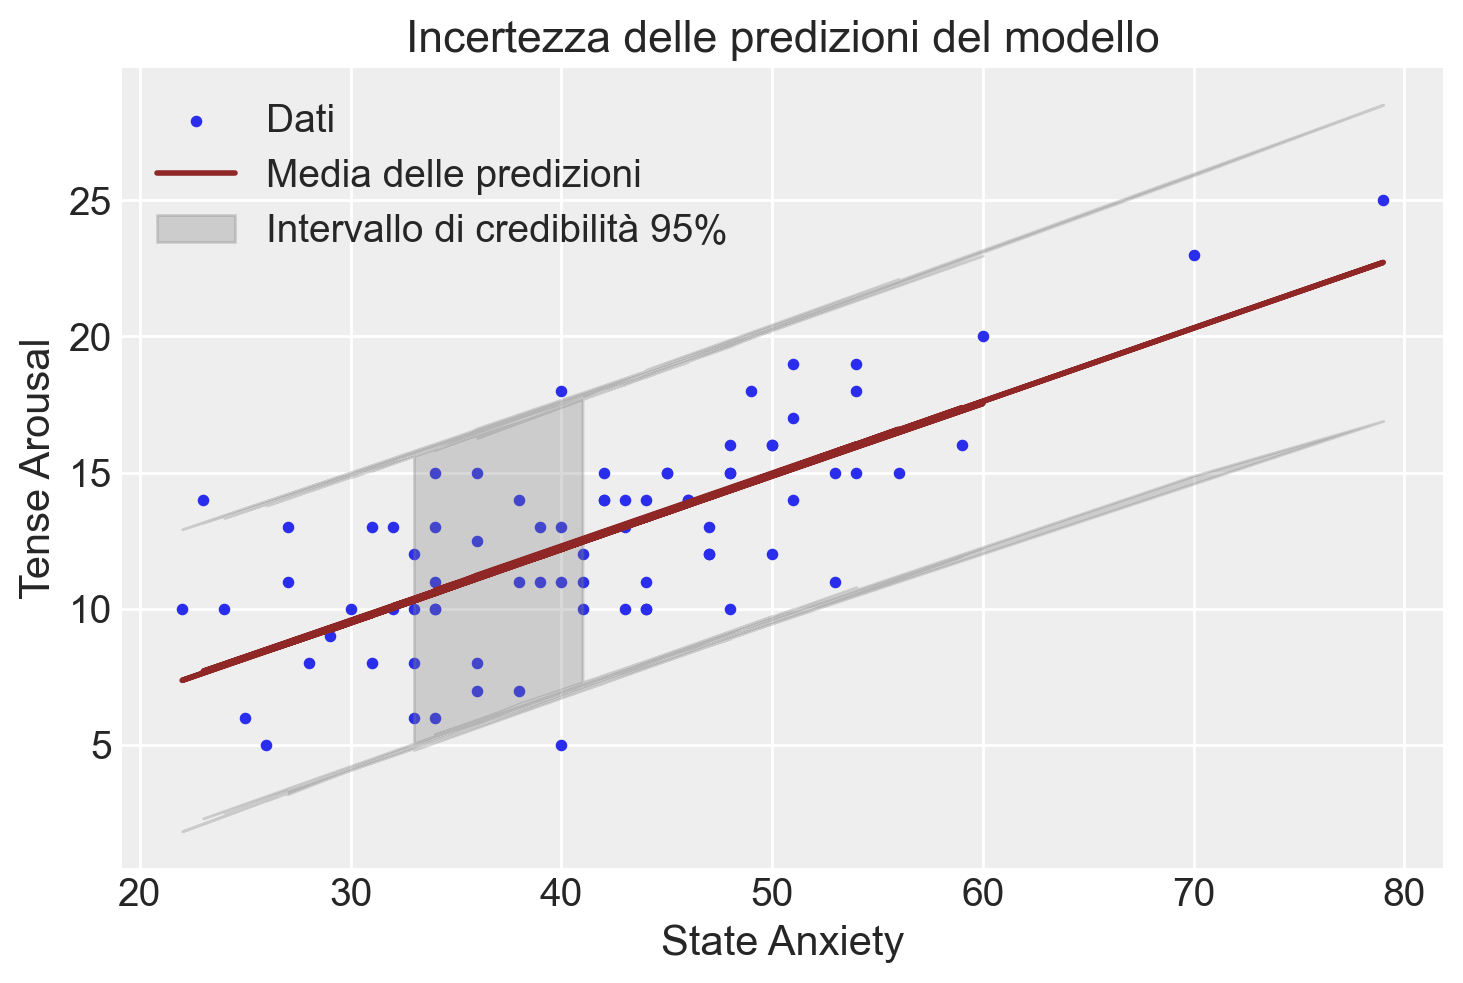

In [19]:
# Estrai i campioni posteriori di y_rep
y_rep_samples = fit3.stan_variable("y_rep")

# Calcola la media e l'intervallo di credibilità (ad esempio, 95%) per y_rep
y_rep_mean = np.mean(y_rep_samples, axis=0)
y_rep_lower = np.percentile(y_rep_samples, 2.5, axis=0)
y_rep_upper = np.percentile(y_rep_samples, 97.5, axis=0)

# Plot y vs x
x = df["state1"]
y = df["TA1"]
plt.scatter(x, y, label="Dati", s=10)

# Plot della media delle predizioni a posteriori
plt.plot(x, y_rep_mean, color=color_edge, linewidth=2, label="Media delle predizioni")

# Plot dell'intervallo di credibilità
plt.fill_between(
    x,
    y_rep_lower,
    y_rep_upper,
    color="gray",
    alpha=0.3,
    label="Intervallo di credibilità 95%",
)

# Formattazione del plot
plt.xlabel("State Anxiety")
plt.ylabel("Tense Arousal")
plt.title("Incertezza delle predizioni del modello")
plt.legend()
plt.show()

Nel primo approccio, calcoliamo l'incertezza delle predizioni utilizzando le distribuzioni a posteriori di `alpha` e `beta`. Questo metodo consiste nel generare predizioni lineari per ciascun campione a posteriori di `alpha` e `beta`, tracciando quindi le linee di regressione risultanti. Questo ci permette di vedere come varia la linea di regressione in base alle incertezze nei parametri `alpha` e `beta`. Questo metodo visualizza come l'incertezza nei parametri del modello si traduce in incertezza nelle predizioni.

Nel secondo approccio, descriviamo l'incertezza delle predizioni utilizzando direttamente la distribuzione a posteriori di `y_rep`. In questo caso, generiamo predizioni per ciascun valore osservato di `x` nel modello Stan, tenendo conto delle distribuzioni a posteriori dei parametri del modello. Questo metodo visualizza direttamente l'incertezza nelle predizioni, tenendo conto delle variazioni nei dati osservati e delle distribuzioni a posteriori dei parametri.

Le due descrizioni dell'incertezza delle predizioni del modello sono diverse perché riflettono aspetti differenti della distribuzione a posteriori:

1. **Distribuzione a posteriori di `alpha` e `beta`**: Questo approccio considera solo l'incertezza nei parametri del modello (`alpha` e `beta`). Le linee di regressione tracciate variano in base a questi parametri, ma non tengono conto dell'incertezza residua (`sigma`).

2. **Distribuzione a posteriori di `y_rep`**: Questo approccio include non solo l'incertezza nei parametri `alpha` e `beta`, ma anche l'incertezza residua (`sigma`). La distribuzione di `y_rep` riflette la variabilità totale nel modello, inclusa la variabilità nei dati osservati. Pertanto, l'incertezza nelle predizioni è maggiore perché tiene conto di tutte le fonti di variabilità.

## Verifica Predittiva delle Distribuzioni a Priori

Le verifiche predittive delle distribuzioni a priori (*prior predictive checks*) costituiscono una parte fondamentale del flusso di lavoro nella modellazione bayesiana. In sostanza, queste verifiche offrono due principali vantaggi:

- Consentono di verificare se si sta effettivamente incorporando la conoscenza scientifica nel modello. In altre parole, aiutano a controllare la credibilità delle ipotesi formulate prima di osservare i dati. Questo passaggio è essenziale per assicurarsi che le assunzioni del modello riflettano realisticamente la realtà che si sta cercando di modellare.

- Possono facilitare il processo di campionamento, limitando lo spazio dei risultati e dei parametri a valori "ragionevoli". In pratica, questa restrizione contribuisce a migliorare l'efficienza del campionamento, evitando che il modello esplori aree dello spazio dei parametri che sono poco plausibili o che producono previsioni irrealistiche.

Consideriamo qui il odello precedente che impone le seguenti distribuzioni a priori sui parametri `alpha`, `beta` e `sigma` del modello di regressione:

$$
\alpha \sim \text{Normal}(0, 5),
$$
$$
\beta \sim \text{Normal}(0, 2.5),
$$
$$
\sigma \sim \text{Chaucy}(0, 5).
$$

La verificha predittiva delle distribuzioni a priori genera un grafico nel quale vengono mostrate un certo numero (qui 30) di rette di regressione, ciascuna delle quali determinata da un valore a caso estratto dalla distribuzione a priori di alpha e un valore a caso estratto dalla distribuzione a priori di beta. 

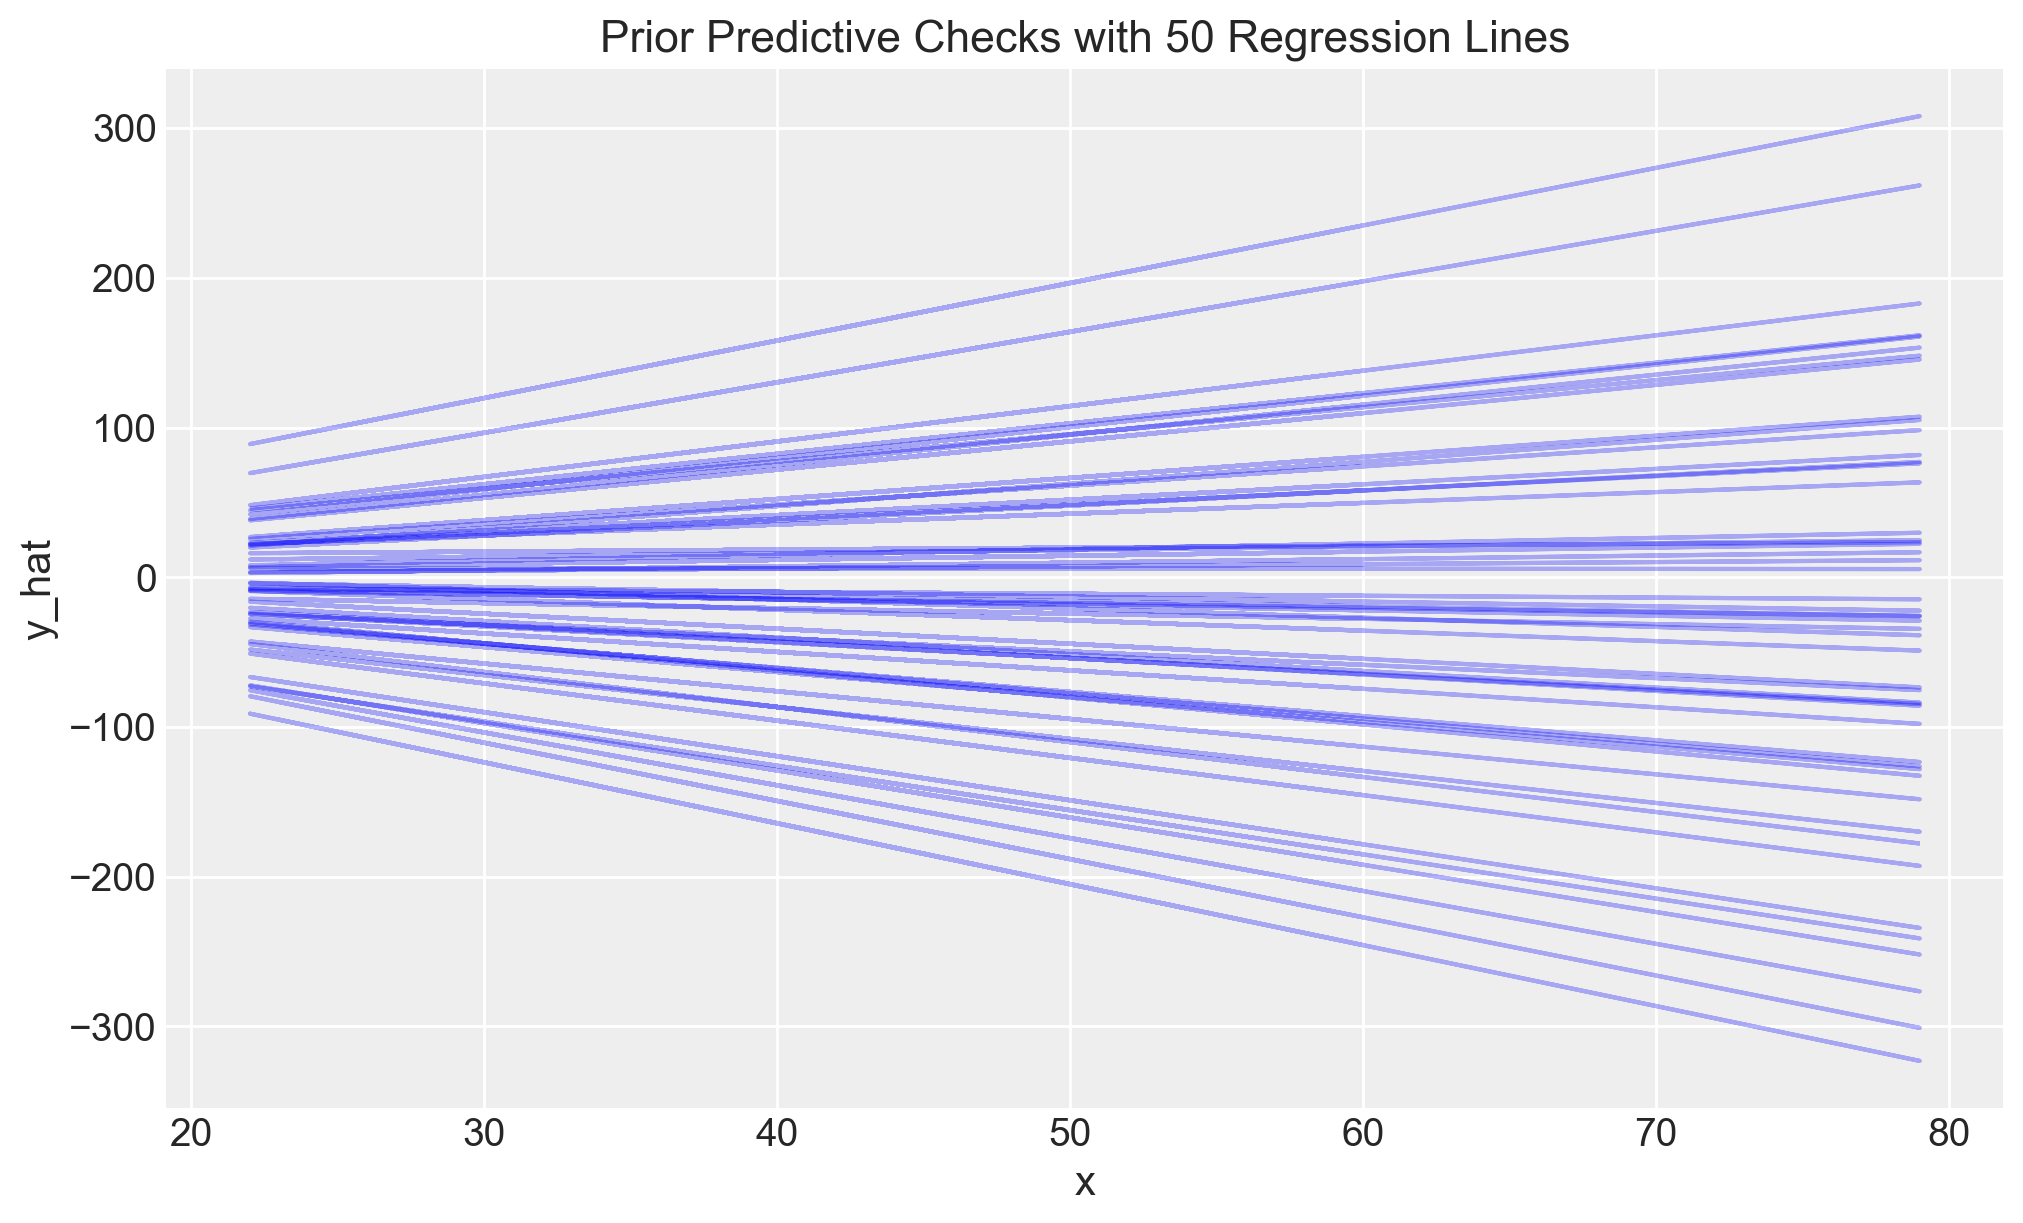

In [20]:
# Number of samples to generate from the prior
num_samples = 50

# Define the prior distributions for alpha and beta
alpha_prior = np.random.normal(0, 5.0, num_samples)
beta_prior = np.random.normal(0, 2.5, num_samples)

# Prepare a figure for plotting
plt.figure(figsize=(10, 6))

# Plot 30 regression lines from the prior distribution
for i in range(num_samples):
    alpha_sample_prior = alpha_prior[i]
    beta_sample_prior = beta_prior[i]

    # Calculate the predicted y_hat without the noise term (sigma)
    y_hat = alpha_sample_prior + beta_sample_prior * x

    # Plot the regression line
    plt.plot(x, y_hat, color="blue", alpha=0.3)

# Optional: Add labels and title to the plot
plt.xlabel("x")
plt.ylabel("y_hat")
plt.title("Prior Predictive Checks with 50 Regression Lines")
plt.show()

Queste distribuzioni a priori consentono di modellare relazioni plausibili tra la variabile dipendente e il predittore. Esse garantiscono che i valori dell'esito rimangano entro un intervallo ragionevole, permettendo al contempo che sia l'intercetta che il coefficiente angolare possano assumere valori sia positivi che negativi.

## Posterior-predictive check

Il Posterior Predictive Check (PPC) è un passaggio cruciale nella modellazione bayesiana, che ci permette di valutare quanto bene il modello si adatta ai dati osservati, tenendo conto delle informazioni aggiornate dai dati stessi. L'idea alla base del PPC è confrontare le predizioni del modello, basate sulla distribuzione a posteriori dei parametri, con i dati reali, per vedere se il modello riesce a catturare correttamente le caratteristiche dei dati osservati.

1. Dopo aver adattato il modello ai dati, otteniamo campioni dai parametri a posteriori ($\alpha$, $\beta$, $\sigma$). Questi campioni riflettono le nostre credenze aggiornate sui parametri, basate sia sulle distribuzioni a priori che sui dati osservati.

2. Utilizzando i campioni della distribuzione a posteriori, simuliamo nuovi dati predetti ($y_{rep}$). Questi dati simulati rappresentano le previsioni del modello, date le nostre stime a posteriori dei parametri.

3. Confrontiamo le osservazioni simulate ($y_{rep}$) con i dati osservati reali ($y$). Il PPC plot ci permette di vedere se il modello, con i parametri aggiornati, è in grado di riprodurre correttamente i dati osservati.

Per creare il PPC plot, usiamo ArviZ. Creiamo un oggetto `InferenceData` che contiene sia le predizioni a posteriori che i dati osservati, organizzati nel formato richiesto da ArviZ.

In [21]:
idata = az.from_cmdstanpy(
    posterior=fit3,
    posterior_predictive="y_rep",
    observed_data={"y": df["TA1"]},
)

Avendo generato l'oggetto `idata`, possiamo ora creare il pp-check plot. 

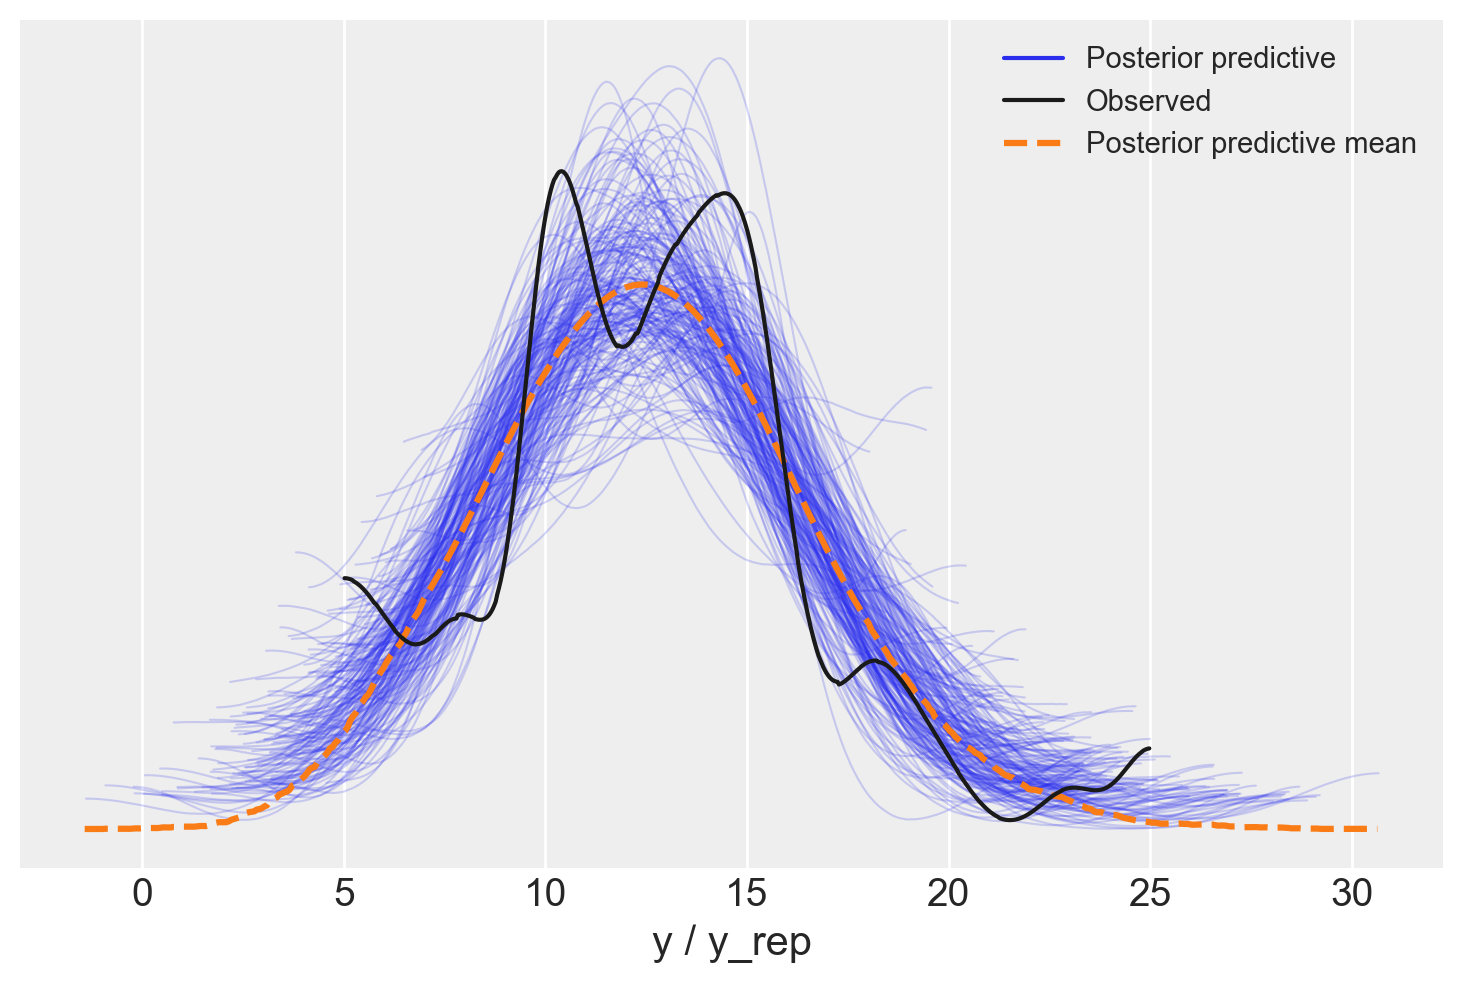

In [22]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=200)

Il Posterior Predictive Check è uno strumento potente per verificare la validità del modello dopo l'analisi, assicurando che le predizioni del modello siano realistiche e che riflettano accuratamente le osservazioni effettive.

## Commenti e Considerazioni Finali

In questo capitolo, abbiamo approfondito i temi della predizione bayesiana nel contesto del modello di regressione bivariato, evidenziando l'importanza delle verifiche predittive a priori e a posteriori per la valutazione e la validazione del modello.

Abbiamo visto come il *Prior Predictive Check* sia essenziale per verificare che le distribuzioni a priori siano appropriate per il modello e i dati del campione. Questo passaggio consente di esaminare se le ipotesi iniziali sono coerenti con la conoscenza preesistente e con i risultati attesi. Un'adeguata verifica predittiva a priori aiuta a prevenire l'adozione di distribuzioni a priori che possano portare a previsioni irrealistiche o fuorvianti. Se le predizioni basate sulle distribuzioni a priori risultano incompatibili con ciò che ci si aspetta dai dati, è un segnale che le distribuzioni a priori devono essere riviste.

Successivamente, abbiamo esaminato il *Posterior Predictive Check* come strumento per valutare la capacità del modello di adattarsi ai dati osservati. Dopo aver integrato le informazioni dei dati con le distribuzioni a priori, il posterior predictive check permette di confrontare le predizioni del modello con i dati effettivamente osservati. Se il modello è adeguato, le sue predizioni dovrebbero essere in linea con i dati reali. Tuttavia, se emerge una discrepanza sostanziale tra le predizioni e i dati osservati, questo è un chiaro segnale che il modello potrebbe non essere appropriato per il fenomeno in esame e potrebbe richiedere una revisione. Tale revisione può comportare la modifica delle assunzioni di base, l'inclusione di nuovi predittori, o l'adozione di un modello completamente diverso.

In conclusione, l'approccio bayesiano alla predizione e alla verifica dei modelli offre un framework robusto e flessibile per l'analisi statistica. I prior e posterior predictive checks non sono semplici passaggi tecnici, ma costituiscono una parte integrante del processo di modellizzazione, assicurando che il modello non solo sia ben adattato ai dati, ma anche che le sue assunzioni siano giustificate e realistiche. L'utilizzo di questi strumenti permette di costruire modelli che siano  coerenti con la realtà che intendono rappresentare.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -m  

Last updated: Tue Aug 13 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
seaborn   : 0.13.2
arviz     : 0.18.0
matplotlib: 3.9.1
sys       : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:13:44) [Clang 16.0.6 ]
pandas    : 2.2.2
cmdstanpy : 1.2.4
logging   : 0.5.1.2

